# This notebook trains a visual content recognition model on *Beyond Words* bounding box annotations (plus additional headline + advertisement annotations). 

*Benjamin Charles Germain Lee*
(LOC Innovator-in-Residence)

This notebook finetunes a pre-trained object detection model (Faster-RCNN R50-FPN) to predict bounding boxes around Photographs, Illustrations, Maps, Comics, Editorial Cartoons, Headlines, and Annotations in historical newspaper images.  The notebook is described in more detail in the newspaper-navigator repo.

This notebook makes the following assumptions:

- The newspaper-navigator repo has been cloned, so the local file structure is intact.
- Detectron2 has been installed.  For Amazon EC2 instances with a Deep Learning Ubuntu AMI, the bash script for installing detectron2 (install-detectron2.sh) can be run to handle the installation (see the repo for more info).

This notebook is based on the following notebook:

- https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5


# First, we handle imports and data formatting.

This cell imports libraries and constructs a COCO instance using the training and validation JSON files; essentially, this enables the model to handle the data loading using the COCO standard:

In [1]:
# to display images inline
%matplotlib inline

# import some common libraries
import cv2
import random
import glob
import os
import shutil
import json
import math
import numpy as np
import matplotlib.pyplot as plt

# import detectron2, etc.
import detectron2
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
setup_logger()

# cd into the beyond words dataset
os.chdir("../beyond_words_data")

# we now register the dataset
register_coco_instances("beyond_words_train", {}, "train_80_percent.json", "images")
register_coco_instances("beyond_words_val", {}, "val_20_percent.json", "images")
register_coco_instances("beyond_words_combined", {}, "trainval.json", "images")

# Next, we visualize some examples.

This cell visualizes some examples from the training set:

WARNING [03/15 21:57:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/15 21:57:05 d2.data.datasets.coco]: Loaded 2748 images in COCO format from train_80_percent.json
images/1578.jpg
images/1723.jpg
images/166.jpg
images/1061.jpg
images/2095.jpg


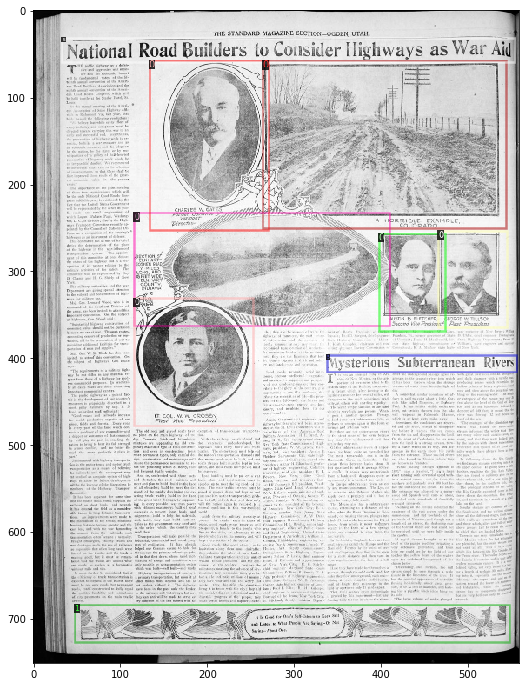

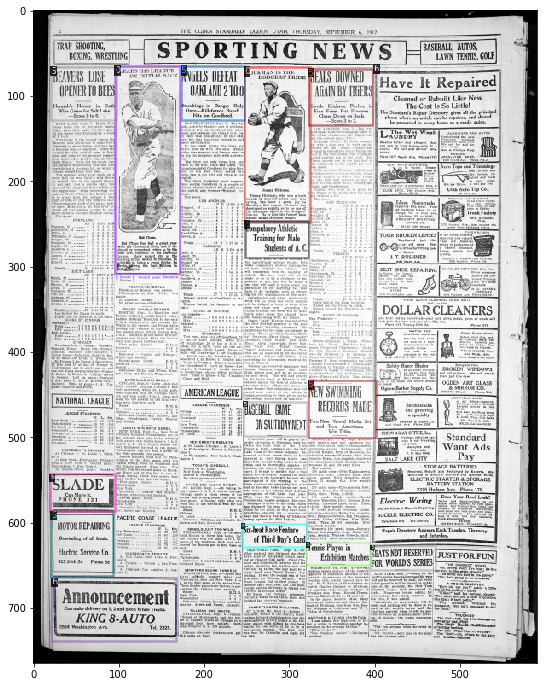

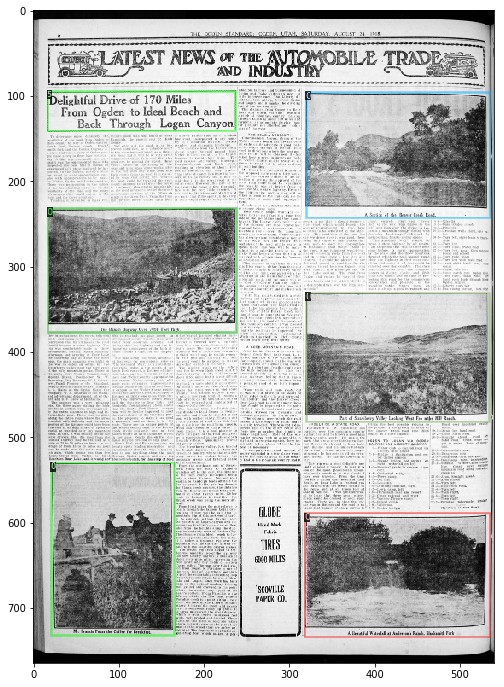

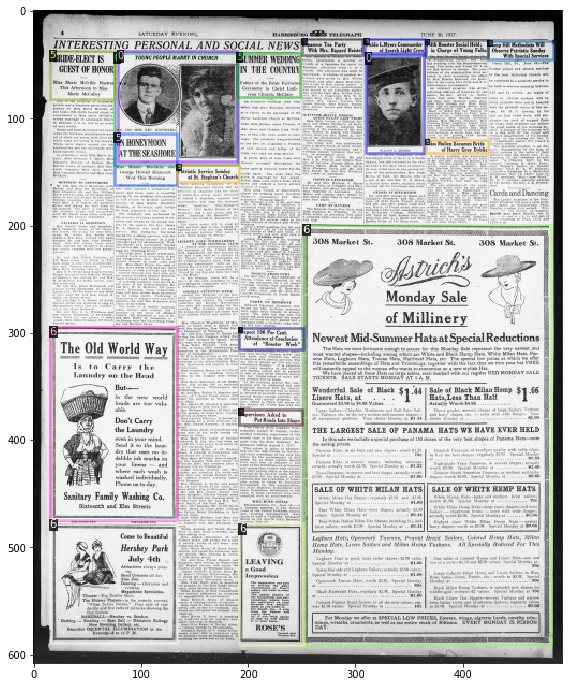

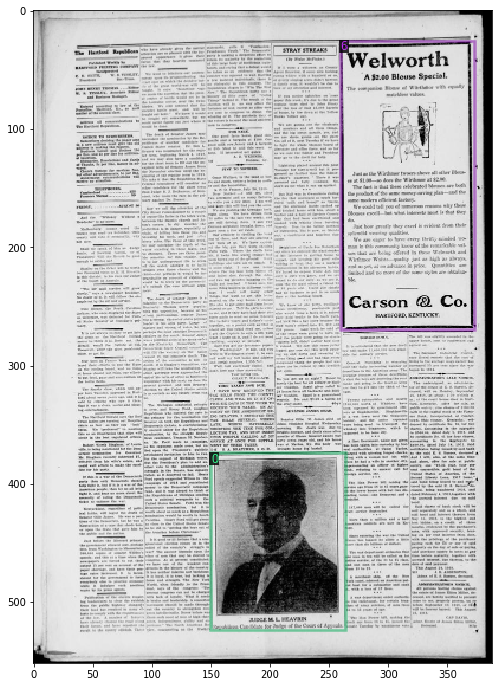

In [2]:
# sets random seed for reproducibility
random.seed(0)

dataset_dicts = DatasetCatalog.get("beyond_words_train")
my_metadata = MetadataCatalog.get("beyond_words_val")

n_examples_to_display = 5
for d in random.sample(dataset_dicts, n_examples_to_display):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_metadata, scale=0.5)
    v = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(15,12))
    plt.imshow(v.get_image()[:, :, ::-1])


# Next, we finetune the Faster-RCNN implementation from Detectron2's Model Zoo.

We can pick our choice of pre-trained model here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

The 7 classes of visual content are:

- Illustration/Photograph
- Photograph
- Comics/Cartoon
- Editorial Cartoon
- Map
- Headline
- Advertisement

Below, we finetune "Faster_rcnn_R_50_FPN_3x" and evaluate mean average precision on the held-out data (80%-20% train-val split); for this demo we run for 10 epochs:


In [3]:
# sets batch size
batch_size = 8
# sets epoch size accordingly (to convert iterations to epochs)
epoch = math.ceil(2748/float(batch_size)) # 344 corresponds to one epoch for the training set
# sets total number of epochs to train for
epoch_num = 10

cfg = get_cfg()
# loads in correct pre-trained model parameters
cfg.merge_from_file("../..//detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
# loads pre-trained model weights (from Model Zoo)
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
# loads in training/val data using the registered COCO instance
cfg.DATASETS.TRAIN = ("beyond_words_train",)
cfg.DATASETS.TEST = ("beyond_words_val",)
# sets number of object classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

# makes output directory for weights, etc.
os.makedirs("../model_weights/", exist_ok=True)

# sets output directory for model weights, checkpoints, etc.
cfg.OUTPUT_DIR = '../model_weights/'

# some hyperparameters
cfg.SOLVER.BASE_LR = 0.00025
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.SOLVER.MAX_ITER = epoch
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8

# sets the testing confidence threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

print("EPOCH 1")

# trains for one epoch
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)  #change here if resuming
trainer.train()

# evaluates on validation data after one epoch
# metrics are printed out to console
trainer.test(trainer.cfg, trainer.model, COCOEvaluator("beyond_words_val", trainer.cfg, False, trainer.cfg.OUTPUT_DIR))

# trains then evaluates on validation data iteratively for desired number of epochs
for i in range(0, epoch_num-1):
    
    print("EPOCH " + str(i+2))

    # trains again
    cfg.SOLVER.MAX_ITER = epoch*(i+2)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=True)
    trainer.train()
    
    trainer.test(trainer.cfg, trainer.model, COCOEvaluator("beyond_words_val", trainer.cfg, False, trainer.cfg.OUTPUT_DIR))


EPOCH 1
[03/15 21:57:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
  

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (8, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (8,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (28, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (28,) in the model! Skipped.


[03/15 21:57:13 d2.engine.train_loop]: Starting training from iteration 0
[03/15 21:57:55 d2.utils.events]: eta: 0:11:24  iter: 19  total_loss: 4.762  loss_cls: 2.114  loss_box_reg: 0.634  loss_rpn_cls: 1.762  loss_rpn_loc: 0.194  time: 2.1096  data_time: 0.1524  lr: 0.000005  max_mem: 8358M
[03/15 21:58:38 d2.utils.events]: eta: 0:10:40  iter: 39  total_loss: 4.029  loss_cls: 2.017  loss_box_reg: 0.619  loss_rpn_cls: 1.198  loss_rpn_loc: 0.194  time: 2.1193  data_time: 0.1342  lr: 0.000010  max_mem: 8781M
[03/15 21:59:20 d2.utils.events]: eta: 0:10:03  iter: 59  total_loss: 3.250  loss_cls: 1.863  loss_box_reg: 0.742  loss_rpn_cls: 0.476  loss_rpn_loc: 0.174  time: 2.1247  data_time: 0.1383  lr: 0.000015  max_mem: 8781M
[03/15 22:00:04 d2.utils.events]: eta: 0:09:25  iter: 79  total_loss: 2.798  loss_cls: 1.666  loss_box_reg: 0.770  loss_rpn_cls: 0.179  loss_rpn_loc: 0.157  time: 2.1397  data_time: 0.1327  lr: 0.000020  max_mem: 8993M
[03/15 22:00:46 d2.utils.events]: eta: 0:08:42  it

# Next, we create a predictor for predicting on examples from the validaton set.

This cell generates a predictor for performing predictions on the validation examples:

In [4]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
cfg.DATASETS.TEST = ("beyond_words_val", )

cfg.merge_from_file("../..//detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
cfg.MODEL.WEIGHTS = "../model_weights/model_final.pth"

predictor = DefaultPredictor(cfg)

# Lastly, we display the predictions.

This cell shows some sample predictions in the notebook itself:

WARNING [03/16 00:13:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/16 00:13:28 d2.data.datasets.coco]: Loaded 688 images in COCO format from val_20_percent.json


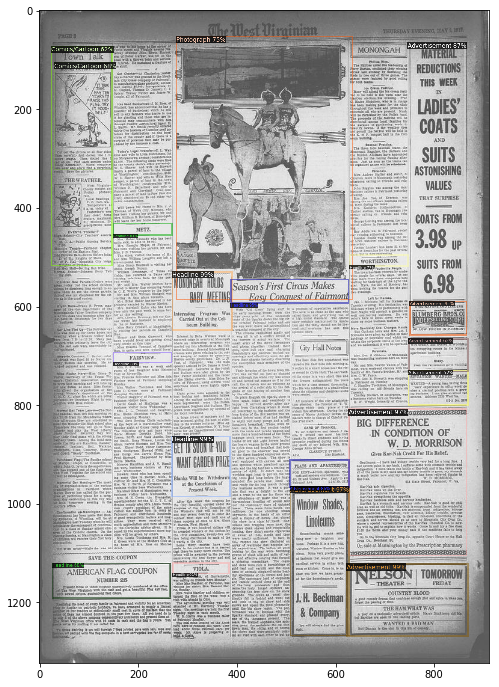

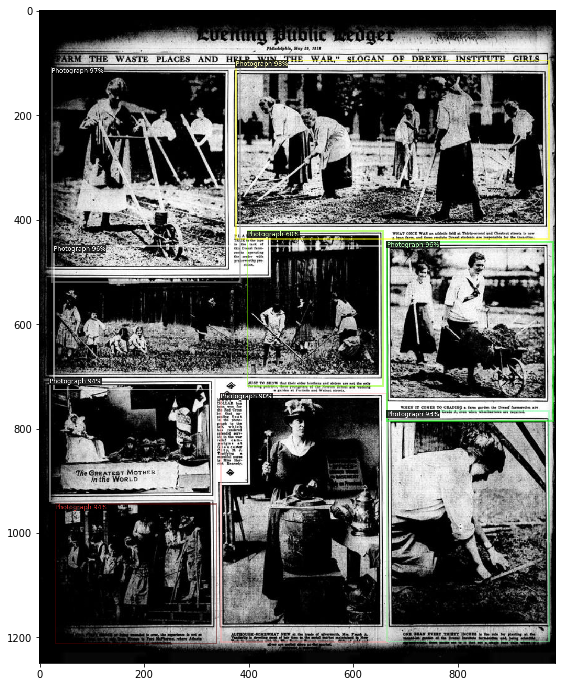

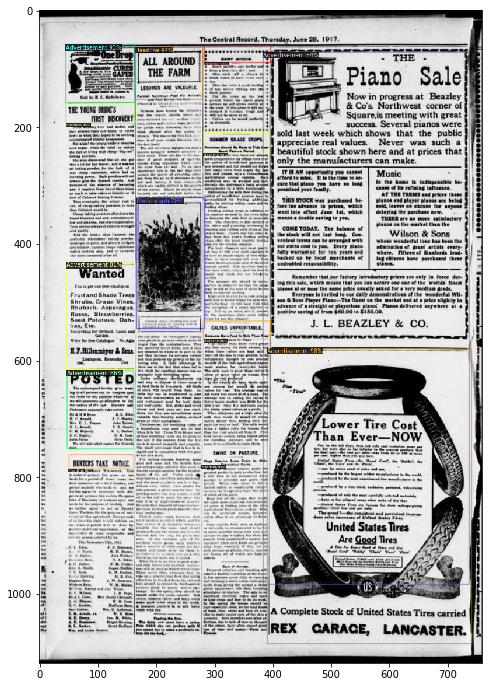

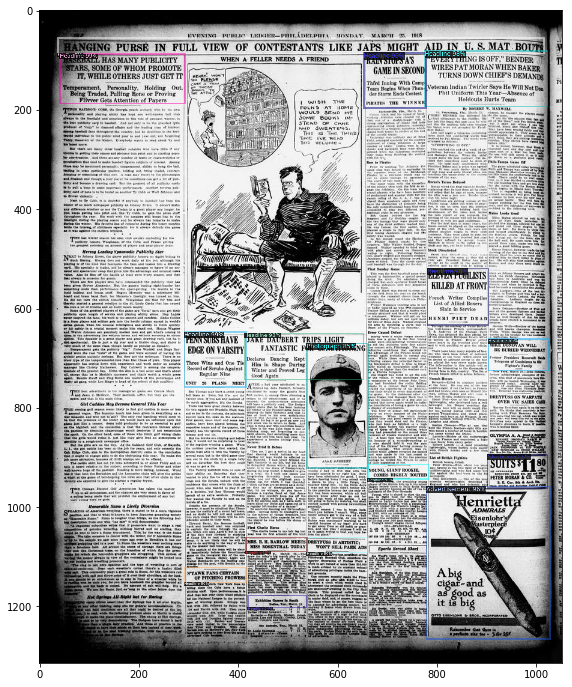

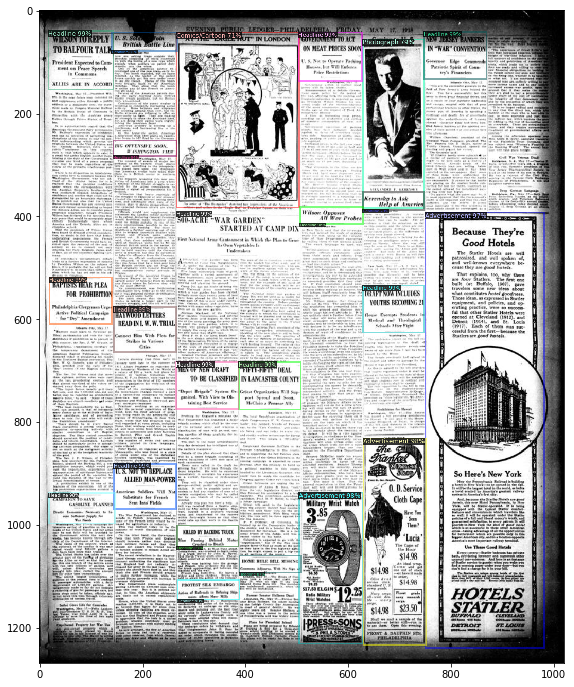

In [5]:
n_test_to_display = 5

for d in random.sample(DatasetCatalog.get("beyond_words_val"), n_test_to_display):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("beyond_words_val"), 
                   scale=1.2   )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #v = v.draw_dataset_dict(d)
    plt.figure(figsize=(15,12))
    plt.imshow(v.get_image()[:, :, ::-1])
    
    # if we want to save the images:
    # cv2.imwrite(filepath_here, v.get_image()[:, :, ::-1])
